In [1]:
%load_ext autoreload
%autoreload 2
# Set HuggingFace cache directory to scratch to save space.
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/' + os.environ['USER'] + '/huggingface_cache'
CACHE_DIR = '/scratch/' + os.environ['USER'] + '/huggingface_cache'
# Optional; can help when memory is tight.
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [78]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True).to('cuda')
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
sum_log = [
    torch.zeros(10240, device='cuda') for _ in range(32)
]
sum_square_log = [
    torch.zeros(10240, device='cuda') for _ in range(32)
]
count = [
    0 for _ in range(32)
]

In [71]:
torch.save((sum_log, sum_square_log, count), "calibration_pmqa.pt")

In [110]:
import numpy as np

"""
from transformers.activations import ACT2FN

class PhiMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.activation_fn = ACT2FN[config.hidden_act]
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = self.activation_fn(hidden_states)
        hidden_states = self.fc2(hidden_states)
        return hidden_states
"""


class LoggingMLP(torch.nn.Module):
    def __init__(self, mlp, id, fixed_neurons):
        super().__init__()
        
        self.mlp = mlp
        self.id = id
        self.fixed_neurons = fixed_neurons
        self.variance = sum_square_log[id]/count[id]
        self.mean = sum_log[id]/count[id]
    
    def forward(self, hidden_states: torch.Tensor):
        
        pre_activation = self.mlp.fc1(hidden_states)
        activation = self.mlp.activation_fn(pre_activation)
        
        mean = self.mean[fixed_neurons].to(activation.dtype)
        var = self.variance[fixed_neurons].to(activation.dtype)
        
        activation[..., fixed_neurons] = mean + torch.sqrt(var) * torch.randn_like(activation[..., fixed_neurons])
        
        # i = self.id
        # sum_log[i] += activation.sum(dim=(0, 1))
        # sum_square_log[i] += (activation ** 2).sum(dim=(0, 1))
        # count[i] += activation.shape[0] * activation.shape[1] # number of tokens it's seen
        
        return self.mlp.fc2(activation)
    

In [79]:
# replace MLP layers
original_mlps = [model.model.layers[i].mlp for i in range(len(model.model.layers))]

In [7]:
import json

data = json.load(open("/scratch/gsk6me/pubmedqa/data/pqaa_dev_set.json"))


In [145]:
for mlp_i in range(len(model.model.layers)):
    layer = mlp_i
    mean = sum_log[layer]/count[layer]
    variance = sum_square_log[layer]/count[layer] - (sum_log[layer]/count[layer])**2
    
    if mlp_i >= 8:
        fixed_neurons = torch.nonzero(((variance.log10()/2) < -1.0)) # & ())
    else:
        fixed_neurons = []
    print(len(fixed_neurons))
    
    model.model.layers[mlp_i].mlp = LoggingMLP(original_mlps[mlp_i], mlp_i, fixed_neurons)

0
0
0
0
0
0
0
0
4559
4193
3855
3772
3924
4131
4258
3833
4085
3628
3792
4276
4334
4704
4252
4315
4361
4315
3453
3027
2632
3104
2622
3667


In [37]:
data['25344367']

{'QUESTION': 'Does fGF10 promote regional foetal cardiomyocyte proliferation and adult cardiomyocyte cell-cycle re-entry?',
 'CONTEXTS': ['Cardiomyocyte proliferation gradually declines during embryogenesis resulting in severely limited regenerative capacities in the adult heart. Understanding the developmental processes controlling cardiomyocyte proliferation may thus identify new therapeutic targets to modulate the cell-cycle activity of cardiomyocytes in the adult heart. This study aims to determine the mechanism by which fibroblast growth factor 10 (FGF10) controls foetal cardiomyocyte proliferation and to test the hypothesis that FGF10 promotes the proliferative capacity of adult cardiomyocytes.',
  'Analysis of Fgf10(-/-) hearts and primary cardiomyocyte cultures reveals that altered ventricular morphology is associated with impaired proliferation of right but not left-ventricular myocytes. Decreased FOXO3 phosphorylation associated with up-regulated p27(kip) (1) levels was obser

In [116]:
import tqdm

if False:
    for key in tqdm.tqdm(list(data.keys()), desc='inferencing'):
        input_text = data[key]['QUESTION'] + ' ' + data[key]['LONG_ANSWER']
        tokens = tokenizer(input_text, return_tensors='pt').to('cuda')
        with torch.no_grad():
            _ = model(**tokens)


In [146]:
input_text = data['25344367']['QUESTION']
tokens = tokenizer(input_text, return_tensors='pt').to('cuda')
result = model.generate(**tokens, max_new_tokens=72)
print(tokenizer.decode(result[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Does fGF10 promote regional foetal cardiomyocyte proliferation and adult cardiomyocyte cell-cycle re-entry?a- and.c.
-pro-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-and-


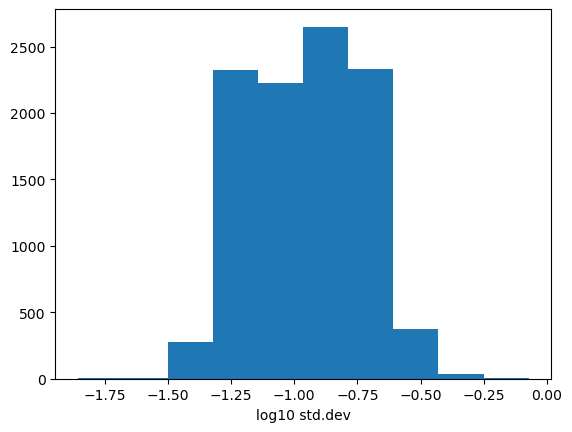

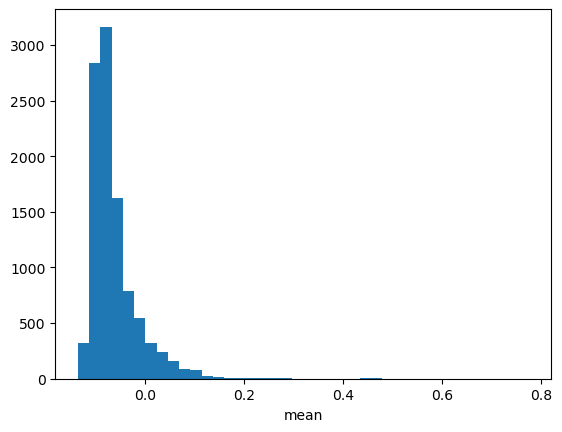

92


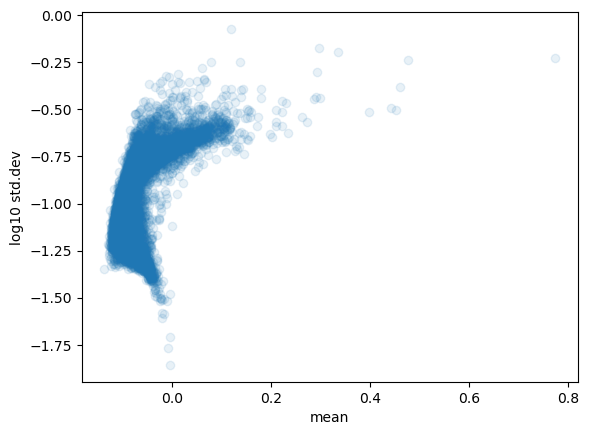

In [128]:
import matplotlib.pyplot as plt

layer = 20
mean = sum_log[layer]/count[layer]
variance = sum_square_log[layer]/count[layer] - (sum_log[layer]/count[layer])**2

plt.hist(variance.log10().detach().cpu().numpy()/2)
plt.xlabel("log10 std.dev")
plt.show()

plt.hist(mean.detach().cpu().numpy(), bins=40)
plt.xlabel("mean")
plt.show()

logstd = variance.log10().detach().cpu().numpy()/2

print((logstd > -0.5).sum())

plt.scatter(mean.detach().cpu().numpy(), logstd, alpha=0.1)
plt.xlabel("mean")
plt.ylabel("log10 std.dev")
plt.show()
